<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/Project_2_Notebook_cfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition

The purpose of this project is to predict house prices (response) from predictor variables using Regression prediction techniques. The goal is to minimize the root mean squared percentage error (RMSPE) on the prediction of house sales price.

This is a supervised regression problem because we want to predict sales price for a house based on multiple predictors.

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import sklearn.model_selection as model_selection

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Functions

In [ ]:
# Root Mean Square Error
def get_rmse(y_test, y_pred):
  value = np.sqrt(mean_squared_error(y_test,y_pred))
  return value.round(2)

# Root Mean Square Percentage Error
def get_rmspe(y_test, y_pred):
  value = np.sqrt(np.mean(np.square((y_test - y_pred)/y_test))) * 100
  return value.round(2)

# Print RMSE and RMSPE for CV
def print_cv_results(mse, label):
  BOLD = '\033[1m'
  DARKCYAN = '\033[36m'
  print(DARKCYAN + BOLD)

  print(label)
  rmse = np.sqrt(abs(mse))
  print(f"CV RMSE: ${rmse.round(2)}")
  rmspe = (rmse / y_test.mean()) * 100
  print(f'CV RMSPE: {rmspe.round(2)}%')

# Print RMSE and RMSPE for model
def print_model_results(y_test, y_pred, label, before=True):
  BOLD = '\033[1m'
  PURPLE = '\033[35m'
  BLUE = '\033[34m'
  GREEN = '\033[32m'

  # Hack
  if label == 'Linear':
    print(GREEN + BOLD)
    print(label)
  else:
    if before:
      print(BLUE + BOLD)
      print(label + ' Before Alpha')
    else:
      print(PURPLE + BOLD)
      print(label + ' After Alpha')

  rmse = get_rmse(y_test, y_pred)
  print(f"RMSE: ${rmse}")
  rmspe = get_rmspe(y_test, y_pred)
  print(f"RMSPE: {rmspe}%")

# Data Collection

The data is a CSV file called HousingData.csv located on Google Drive. 

Here is a [link](https://drive.google.com/file/d/1KKbZ5xj750o7uOz7Tk84QlPiya4UX9FN/view?usp=sharing) to the data dictionary for the dataset.

## Load Data

Data was provided on a Google Drive by the insructor.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Load Data
data_path = '/drive/My Drive/Cohort_6/Projects/Project 2/Data/Housing Data.csv'
data = pd.read_csv(data_path)

# Data Cleaning

Data cleaning began with a high-level view of the columns to determine number of records, number of columns, volume of null (missing) values, and which values were continuous vs discrete.

Throughout the data cleaning process, the data specification was used to better understand the definition of columns and their values.

Columns that contained a large number of null values (over 80%) were removed. Remaining null values were filled with zeroes or with a value provided in the specification to indicate the absence of that feature.

Finally, columns containing non-numeric qualititative values were encoded into numeric qualitative values necessary to run correlations and apply statistical models to the data.

In [ ]:
# Create copy of data that will be clean data
data_clean = data.copy();

In [ ]:
# Get preliminary look at the data
data.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,4,3,1964,1964,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,513.0,LwQ,144.0,348.0,1005.0,GasA,...,Y,SBrkr,1005,0,0,1005,1.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1964.0,Unf,2.0,440.0,TA,TA,N,0,0,0,0,0,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1967,1967,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,...,Y,SBrkr,1296,0,0,1296,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,CarPort,1967.0,Unf,2.0,516.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,6,6,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,PConc,TA,TA,No,Unf,0.0,Unf,0.0,780.0,780.0,GasA,...,Y,SBrkr,780,595,0,1375,0.0,0.0,1,1,3,1,Gd,6,Typ,1,Gd,Detchd,1979.0,Unf,1.0,544.0,TA,TA,P,0,162,0,0,126,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,484.0,Unf,0.0,491.0,975.0,GasA,...,Y,SBrkr,975,873,0,1848,1.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2000.0,RFn,2.0,592.0,TA,TA,Y,280,184,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Feedr,Norm,1Fam,2Story,7,9,1936,2007,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,PConc,Gd,Gd,No,ALQ,350.0,BLQ,210.0,0.0,560.0,GasA,...,Y,SBrkr,575,560,0,1135,1.0,0.0,1,0,3,1,Gd,6,Typ,0,NaN,Detchd,1971.0,RFn,2.0,576.0,TA,TA,Y,256,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000


In [ ]:
# Check data types and other information about the dataset
# 2637 records
# 81 columns
# Sale Price is target column
# PID is unique identifier for rows - not important for analysis
row_count = len(data.index)
print(row_count)
data.info()

2637
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2637 non-null   int64  
 1   MS SubClass      2637 non-null   int64  
 2   MS Zoning        2637 non-null   object 
 3   Lot Frontage     2188 non-null   float64
 4   Lot Area         2637 non-null   int64  
 5   Street           2637 non-null   object 
 6   Alley            180 non-null    object 
 7   Lot Shape        2637 non-null   object 
 8   Land Contour     2637 non-null   object 
 9   Utilities        2637 non-null   object 
 10  Lot Config       2637 non-null   object 
 11  Land Slope       2637 non-null   object 
 12  Neighborhood     2637 non-null   object 
 13  Condition 1      2637 non-null   object 
 14  Condition 2      2637 non-null   object 
 15  Bldg Type        2637 non-null   object 
 16  House Style      2637 non-null   object 
 17  Overall Q

In [ ]:
# Identify data types
data.dtypes.value_counts()

object     43
int64      27
float64    11
dtype: int64

## Identify nulls

Nulls were identified by column. Then a percentage was calculated for each column to identify which columns had a large percentage of null values. Any columns with null percentages over 80% were deleted. Any columns with null percentages below 80% were evaluated and either deleted or filled with acceptable non-null values based on data type and the data specification.

In [ ]:
# Identify nulls by column
# Identified columns that have large percentage of nulls. 

# Get columns with nulls
nulls = data.isnull().sum()
nulls = nulls[nulls > 0]
print(nulls)
print('-'*20)
# See what percentage of the rows have nulls for columns containing nulls
nulls = (nulls/row_count) * 100
nulls_df = nulls.to_frame()
nulls_df.columns=['null_pct']
print('Large number of nulls')
nulls_df_big = nulls_df[nulls_df['null_pct'] > 40]
print(nulls_df_big)
print('-'*20)
print('Small number of nulls')
nulls_df_small = nulls_df[(nulls_df['null_pct'] <= 40)]
print(nulls_df_small)

Lot Frontage       449
Alley             2457
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           73
Bsmt Cond           73
Bsmt Exposure       76
BsmtFin Type 1      73
BsmtFin SF 1         1
BsmtFin Type 2      74
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1284
Garage Type        145
Garage Yr Blt      147
Garage Finish      147
Garage Cars          1
Garage Area          1
Garage Qual        147
Garage Cond        147
Pool QC           2626
Fence             2109
Misc Feature      2541
dtype: int64
--------------------
Large number of nulls
               null_pct
Alley         93.174061
Fireplace Qu  48.691695
Pool QC       99.582859
Fence         79.977247
Misc Feature  96.359499
--------------------
Small number of nulls
                 null_pct
Lot Frontage    17.026925
Mas Vnr Type     0.872203
Mas Vnr Area     0.872203
Bsmt Qual        2.768297
Bsmt Cond        2.768297
Bsm

## Fill Missing Values

Value counts were taken on all columns with nulls. Data was evaluated to determine if the nulls would ge filled in with alternate values or if the column would be deleted. If there were a small number of nulls, then nulls were replaced with zero for continuous columns and whatever code was specified as None or NA in the data sheet for categorical data.

Changes were made directly in the dataset.

In [ ]:
# Fill in null values on columns based on data type and data specification
data_clean['Mas Vnr Type'].fillna('None', inplace=True)
data_clean['Mas Vnr Area'].fillna(0, inplace=True)
data_clean['Bsmt Cond'].fillna('NA', inplace=True)
data_clean['Bsmt Exposure'].fillna('NA', inplace=True)
data_clean['BsmtFin Type 1'].fillna('NA', inplace=True)
data_clean['BsmtFin SF 1'].fillna(0, inplace=True)
data_clean['Bsmt Unf SF'].fillna(0, inplace=True)
data_clean['Total Bsmt SF'].fillna(0, inplace=True)
data_clean['Bsmt Full Bath'].fillna(0, inplace=True)
data_clean['Bsmt Half Bath'].fillna(0, inplace=True)
data_clean['Garage Type'].fillna('NA', inplace=True)
data_clean['Garage Finish'].fillna('NA', inplace=True)
data_clean['Garage Cars'].fillna(0, inplace=True)

## Remove columns

After reviewing the data, columns were removed that were deemed unlikely to support a Sale Price prediction based on the following criteria:

* Was a non-predictor column such as the row id.
* Had a high percentage of null values (more than 80%).
* Appeared redundant. i.e. Similar values with similar data variability contained in another column.
* Had very little variability in values; More than 90% fell in a single category.


In [ ]:
# Remove unneeded columns based on criteria listed above.
data_clean.drop(['PID','Lot Frontage','Garage Yr Blt','Utilities','Land Slope','Land Contour',
               'Condition 2','Roof Matl','Exterior 2nd','Exter Qual','Bsmt Qual',
               'Garage Qual','Garage Cond','BsmtFin Type 2','BsmtFin SF 2','Heating',
               'Electrical','Functional','Alley','Pool QC','Misc Feature',
               'Fence','Fireplace Qu','Garage Area'], axis=1, inplace=True)


In [ ]:
# Verify no nulls exist after data cleaned
data_clean.isnull().sum().sum()


0

## Encode columns

After nulls were elminated and unnecessary columns were removed, remaining columns containing discrete non-numeric data were encoded (converted to numeric equivalents).

This process was necessary because the analysis engines used required numeric data to operate.

A dataset containing the original values was retained as a data dictionary to allow for translation between original and encoded values.

In [ ]:
# Encode data so can run correlations to determine which columns to keep
labelencoder = LabelEncoder()
data_clean['Condition 1 Lb'] = labelencoder.fit_transform(data_clean['Condition 1'])
data_clean['MS Zoning Lb'] = labelencoder.fit_transform(data_clean['MS Zoning'])
data_clean['Street Lb'] = data_clean['Street'].replace({'Pave': 0, 'Grvl': 1})
data_clean['Lot Shape Lb'] = labelencoder.fit_transform(data_clean['Lot Shape'])
data_clean['Neighborhood Lb'] = labelencoder.fit_transform(data_clean['Neighborhood'])
data_clean['Lot Config Lb'] = labelencoder.fit_transform(data_clean['Lot Config'])
data_clean['Bldg Type Lb'] = labelencoder.fit_transform(data_clean['Bldg Type'])
data_clean['House Style Lb'] = labelencoder.fit_transform(data_clean['House Style'])
data_clean['Roof Style Lb'] = labelencoder.fit_transform(data_clean['Roof Style'])
data_clean['Exterior 1st Lb'] = labelencoder.fit_transform(data_clean['Exterior 1st'])
data_clean['Mas Vnr Type Lb'] = labelencoder.fit_transform(data_clean['Mas Vnr Type'])
data_clean['Bsmt Cond Lb'] = labelencoder.fit_transform(data_clean['Bsmt Cond'])
data_clean['Exter Cond Lb'] = labelencoder.fit_transform(data_clean['Exter Cond'])
data_clean['Foundation Lb'] = labelencoder.fit_transform(data_clean['Foundation'])
data_clean['Bsmt Exposure Lb'] = labelencoder.fit_transform(data_clean['Bsmt Exposure'])
data_clean['BsmtFin Type 1 Lb'] = labelencoder.fit_transform(data_clean['BsmtFin Type 1'])
data_clean['Heating QC Lb'] = labelencoder.fit_transform(data_clean['Heating QC'])
data_clean['Central Air Lb'] = data_clean['Central Air'].replace({'N': 0, 'Y': 1})
data_clean['Kitchen Qual Lb'] = labelencoder.fit_transform(data_clean['Kitchen Qual'])
data_clean['Garage Type Lb'] = labelencoder.fit_transform(data_clean['Garage Type'])
data_clean['Garage Finish Lb'] = labelencoder.fit_transform(data_clean['Garage Finish'])
data_clean['Paved Drive Lb'] = data_clean['Paved Drive'].replace({'N': 0, 'Y': 1, 'P': 2})
data_clean['Sale Type Lb'] = labelencoder.fit_transform(data_clean['Sale Type'])
data_clean['Sale Condition Lb'] = labelencoder.fit_transform(data_clean['Sale Condition'])

data_clean.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Lot Config,Neighborhood,Condition 1,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Mas Vnr Type,Mas Vnr Area,Exter Cond,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,...,Garage Type,Garage Finish,Garage Cars,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Condition 1 Lb,MS Zoning Lb,Street Lb,Lot Shape Lb,Neighborhood Lb,Lot Config Lb,Bldg Type Lb,House Style Lb,Roof Style Lb,Exterior 1st Lb,Mas Vnr Type Lb,Bsmt Cond Lb,Exter Cond Lb,Foundation Lb,Bsmt Exposure Lb,BsmtFin Type 1 Lb,Heating QC Lb,Central Air Lb,Kitchen Qual Lb,Garage Type Lb,Garage Finish Lb,Paved Drive Lb,Sale Type Lb,Sale Condition Lb
0,20,RL,14299,Pave,Reg,Inside,Sawyer,Feedr,1Fam,1Story,4,3,1964,1964,Gable,HdBoard,None,0.0,TA,CBlock,TA,No,Rec,513.0,348.0,1005.0,TA,Y,1005,0,0,1005,1.0,0.0,1,0,3,1,TA,5,...,Detchd,Unf,2.0,N,0,0,0,0,0,0,0,7,2007,WD,Normal,115400,1,5,0,3,22,4,0,2,1,6,3,5,4,1,4,5,4,1,3,5,3,0,9,4
1,90,RL,10791,Pave,Reg,Inside,Sawyer,Norm,Duplex,1Story,4,5,1967,1967,Gable,MetalSd,None,0.0,TA,Slab,NA,NA,NA,0.0,0.0,0.0,TA,Y,1296,0,0,1296,0.0,0.0,2,0,2,2,TA,6,...,CarPort,Unf,2.0,Y,0,0,0,0,0,0,500,10,2006,WD,Normal,90000,2,5,0,3,22,4,2,2,1,8,3,3,4,3,3,4,4,1,3,4,3,1,9,4
2,50,RM,9000,Pave,Reg,Inside,IDOTRR,Norm,1Fam,1.5Fin,6,6,1937,1950,Gable,Wd Sdng,None,0.0,Gd,PConc,TA,No,Unf,0.0,780.0,780.0,TA,Y,780,595,0,1375,0.0,0.0,1,1,3,1,Gd,6,...,Detchd,Unf,1.0,P,0,162,0,0,126,0,0,12,2007,WD,Normal,141000,2,6,0,3,11,4,0,0,1,14,3,5,2,2,4,6,4,1,2,5,3,2,9,4
3,60,FV,7379,Pave,IR1,Inside,Somerst,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,None,0.0,TA,PConc,TA,No,GLQ,484.0,491.0,975.0,Ex,Y,975,873,0,1848,1.0,0.0,2,1,3,1,Gd,7,...,Attchd,RFn,2.0,Y,280,184,0,0,0,0,0,4,2010,WD,Normal,254000,2,2,0,0,24,4,0,5,1,13,3,5,4,2,4,2,0,1,2,1,2,1,9,4
4,70,RL,7200,Pave,Reg,Inside,SWISU,Feedr,1Fam,2Story,7,9,1936,2007,Gable,Wd Sdng,None,0.0,Gd,PConc,Gd,No,ALQ,350.0,0.0,560.0,Ex,Y,575,560,0,1135,1.0,0.0,1,0,3,1,Gd,6,...,Detchd,RFn,2.0,Y,256,0,0,0,0,0,0,4,2009,WD,Normal,155000,1,5,0,3,21,4,0,5,1,14,3,2,2,2,4,0,0,1,2,5,2,1,9,4


In [ ]:
# Create copy that contains only encoded and numeric values. 
data_enc = data_clean.copy()

data_enc.drop(['MS Zoning','Street','Lot Shape','Neighborhood','Lot Config','Bldg Type',
               'House Style','Roof Style','Exterior 1st','Mas Vnr Type','Bsmt Cond',
               'Exter Cond','Foundation','Bsmt Exposure','BsmtFin Type 1','Heating QC',
               'Central Air','Kitchen Qual','Garage Type','Garage Finish','Paved Drive',
               'Sale Type','Sale Condition','Condition 1'], axis=1, inplace=True)

# Verify all values have been encoded.
data_enc.head()


,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Condition 1 Lb,MS Zoning Lb,Street Lb,Lot Shape Lb,Neighborhood Lb,Lot Config Lb,Bldg Type Lb,House Style Lb,Roof Style Lb,Exterior 1st Lb,Mas Vnr Type Lb,Bsmt Cond Lb,Exter Cond Lb,Foundation Lb,Bsmt Exposure Lb,BsmtFin Type 1 Lb,Heating QC Lb,Central Air Lb,Kitchen Qual Lb,Garage Type Lb,Garage Finish Lb,Paved Drive Lb,Sale Type Lb,Sale Condition Lb
0,20,14299,4,3,1964,1964,0.0,513.0,348.0,1005.0,1005,0,0,1005,1.0,0.0,1,0,3,1,5,0,2.0,0,0,0,0,0,0,0,7,2007,115400,1,5,0,3,22,4,0,2,1,6,3,5,4,1,4,5,4,1,3,5,3,0,9,4
1,90,10791,4,5,1967,1967,0.0,0.0,0.0,0.0,1296,0,0,1296,0.0,0.0,2,0,2,2,6,0,2.0,0,0,0,0,0,0,500,10,2006,90000,2,5,0,3,22,4,2,2,1,8,3,3,4,3,3,4,4,1,3,4,3,1,9,4
2,50,9000,6,6,1937,1950,0.0,0.0,780.0,780.0,780,595,0,1375,0.0,0.0,1,1,3,1,6,1,1.0,0,162,0,0,126,0,0,12,2007,141000,2,6,0,3,11,4,0,0,1,14,3,5,2,2,4,6,4,1,2,5,3,2,9,4
3,60,7379,8,5,2000,2000,0.0,484.0,491.0,975.0,975,873,0,1848,1.0,0.0,2,1,3,1,7,1,2.0,280,184,0,0,0,0,0,4,2010,254000,2,2,0,0,24,4,0,5,1,13,3,5,4,2,4,2,0,1,2,1,2,1,9,4
4,70,7200,7,9,1936,2007,0.0,350.0,0.0,560.0,575,560,0,1135,1.0,0.0,1,0,3,1,6,0,2.0,256,0,0,0,0,0,0,4,2009,155000,1,5,0,3,21,4,0,5,1,14,3,2,2,2,4,0,0,1,2,5,2,1,9,4


# Exploratory Data Analysis (EDA)

Once data cleaning was complete, the data was further analyzed to determine which columns would qualify as predictor columns. This analysis was performed using **correlations** between the response (SalePrice) and other columns as well as correlations between predictor columns. Additional analysis was performed using **histograms and scatter plots**.

## Correlations

**Steps:**

1. Identify correlations with SalePrice. Remove any predictors that do not have an effect on SalePrice (i.e. low correlation).
1. Identify correlations between predictors. Remove some predictors that are highly correlated - have sibling predictors i.e. garage type and garage finish - as they are extraneous for this analysis.

Initially I looked at correlations over .60. However, when I included features that had lower correlations, the model performed better. It seemed that more predictors resulted in better model performance with RMSPE dropping from around 19% to around 16%.

It was also observed that rating systems differed between predictors. Some predictors gave a high value for high quality and a low value for poor quality. Some predictors gave a high value for low quality and a low value for high quality. This resulted in a negative correlation in such cases.

In [ ]:
# Note: Some items have low correlations when I would have expected higher correlation
# with sale price based on my personal house purchasing/selling experience.

# Look at clean data to see which columns can be used as predictors
corr = data_enc.corr()['SalePrice'].round(2)
correlated_vars = abs(corr).sort_values(ascending=False)
correlated_vars

SalePrice            1.00
Overall Qual         0.81
Gr Liv Area          0.71
Garage Cars          0.65
Total Bsmt SF        0.63
Kitchen Qual Lb      0.63
1st Flr SF           0.62
Year Built           0.56
Year Remod/Add       0.54
Full Bath            0.54
Mas Vnr Area         0.50
TotRms AbvGrd        0.49
Fireplaces           0.47
Garage Finish Lb     0.44
Garage Type Lb       0.43
Heating QC Lb        0.43
BsmtFin SF 1         0.43
Foundation Lb        0.41
Wood Deck SF         0.32
Bsmt Exposure Lb     0.31
Open Porch SF        0.31
Lot Shape Lb         0.30
Half Bath            0.29
Bsmt Full Bath       0.28
Lot Area             0.27
2nd Flr SF           0.27
Central Air Lb       0.27
Roof Style Lb        0.26
Sale Condition Lb    0.24
Neighborhood Lb      0.21
Bsmt Unf SF          0.18
Paved Drive Lb       0.18
House Style Lb       0.17
Enclosed Porch       0.14
Exterior 1st Lb      0.14
Bedroom AbvGr        0.13
Mas Vnr Type Lb      0.13
BsmtFin Type 1 Lb    0.13
MS Zoning Lb

In [ ]:
# Keep predictors that have correlation over 30% with SalePrice
corr_lower_threshold = .30

In [ ]:
# Also look at correlations between all columns.
corrs = data_enc.corr().round(2).unstack().abs()
# No need to look at correlation = 1 since this is where predictors are correlated with themselves.
# Only look at correlations between lower threshold and .99
corrs = corrs[(corrs < 1) & (corrs > corr_lower_threshold)]
corrs = corrs.sort_values(ascending=False)
corrs.iloc[:50]

SalePrice          Overall Qual         0.81
Overall Qual       SalePrice            0.81
TotRms AbvGrd      Gr Liv Area          0.81
Gr Liv Area        TotRms AbvGrd        0.81
Total Bsmt SF      1st Flr SF           0.78
1st Flr SF         Total Bsmt SF        0.78
MS SubClass        Bldg Type Lb         0.74
Bldg Type Lb       MS SubClass          0.74
SalePrice          Gr Liv Area          0.71
Gr Liv Area        SalePrice            0.71
TotRms AbvGrd      Bedroom AbvGr        0.68
Bedroom AbvGr      TotRms AbvGrd        0.68
Gr Liv Area        2nd Flr SF           0.66
2nd Flr SF         Gr Liv Area          0.66
Garage Cars        SalePrice            0.65
SalePrice          Garage Cars          0.65
BsmtFin SF 1       Bsmt Full Bath       0.64
Bsmt Full Bath     BsmtFin SF 1         0.64
Full Bath          Gr Liv Area          0.63
SalePrice          Kitchen Qual Lb      0.63
Kitchen Qual Lb    SalePrice            0.63
SalePrice          Total Bsmt SF        0.63
Foundation

### Remove Additional Columns

In [ ]:
# Drop columns with low correlation to SalePrice
cols_to_drop = correlated_vars.to_frame()
cols_to_drop = cols_to_drop[cols_to_drop['SalePrice'] < corr_lower_threshold]
for row in range(len(cols_to_drop.index)):
  data_enc.drop(cols_to_drop.index[row], inplace=True, axis=1)

data_enc.head()

,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Wood Deck SF,Open Porch SF,SalePrice,Lot Shape Lb,Foundation Lb,Bsmt Exposure Lb,Heating QC Lb,Kitchen Qual Lb,Garage Type Lb,Garage Finish Lb
0,4,1964,1964,0.0,513.0,1005.0,1005,1005,1,5,0,2.0,0,0,115400,3,1,4,4,3,5,3
1,4,1967,1967,0.0,0.0,0.0,1296,1296,2,6,0,2.0,0,0,90000,3,3,3,4,3,4,3
2,6,1937,1950,0.0,0.0,780.0,780,1375,1,6,1,1.0,0,162,141000,3,2,4,4,2,5,3
3,8,2000,2000,0.0,484.0,975.0,975,1848,2,7,1,2.0,280,184,254000,0,2,4,0,2,1,2
4,7,1936,2007,0.0,350.0,560.0,575,1135,1,6,0,2.0,256,0,155000,3,2,4,0,2,5,2


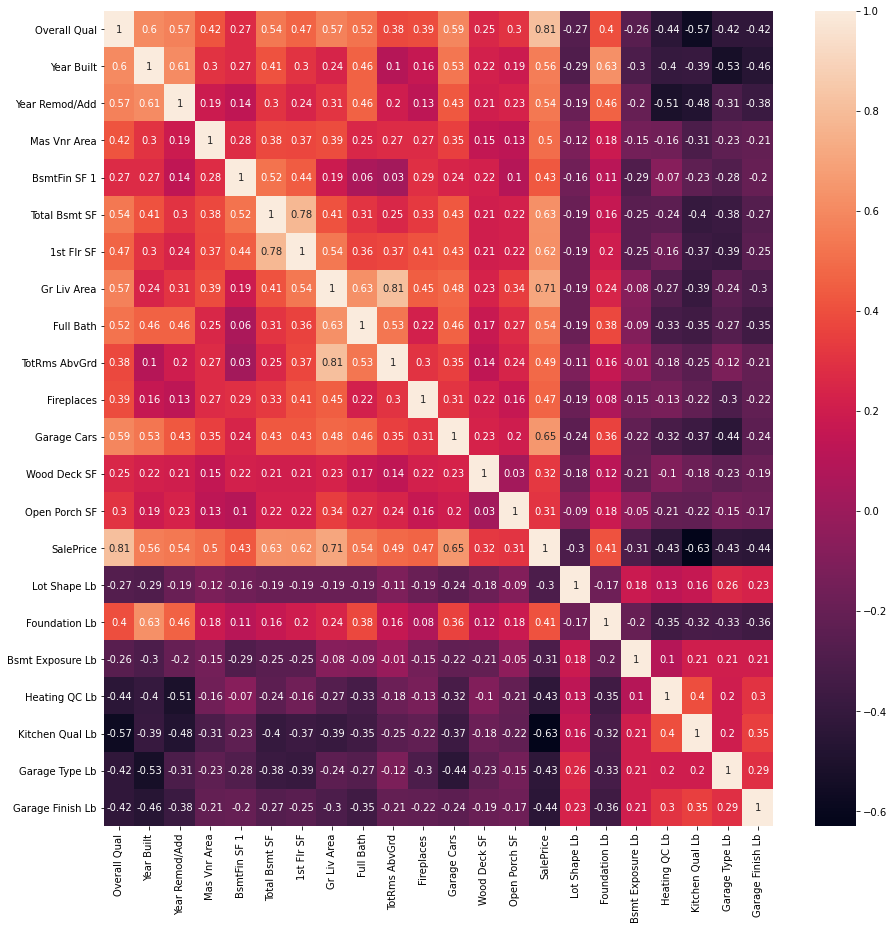

In [ ]:
# Create correlation plot to see if any of the remaining predictors are highly correlated.
# If they are, then we can further reduce the number of predictors as unnecessary
#  since we don't need every predictor. 
plt.figure(figsize=(15,15))
correlation_matrix = data_enc.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [ ]:
# With remaining columns create scatter plots and histograms to further see relationships
#   between columns

# Note: commented out because this takes a long time to run due to the number of columns.
# sns.pairplot(data_enc)

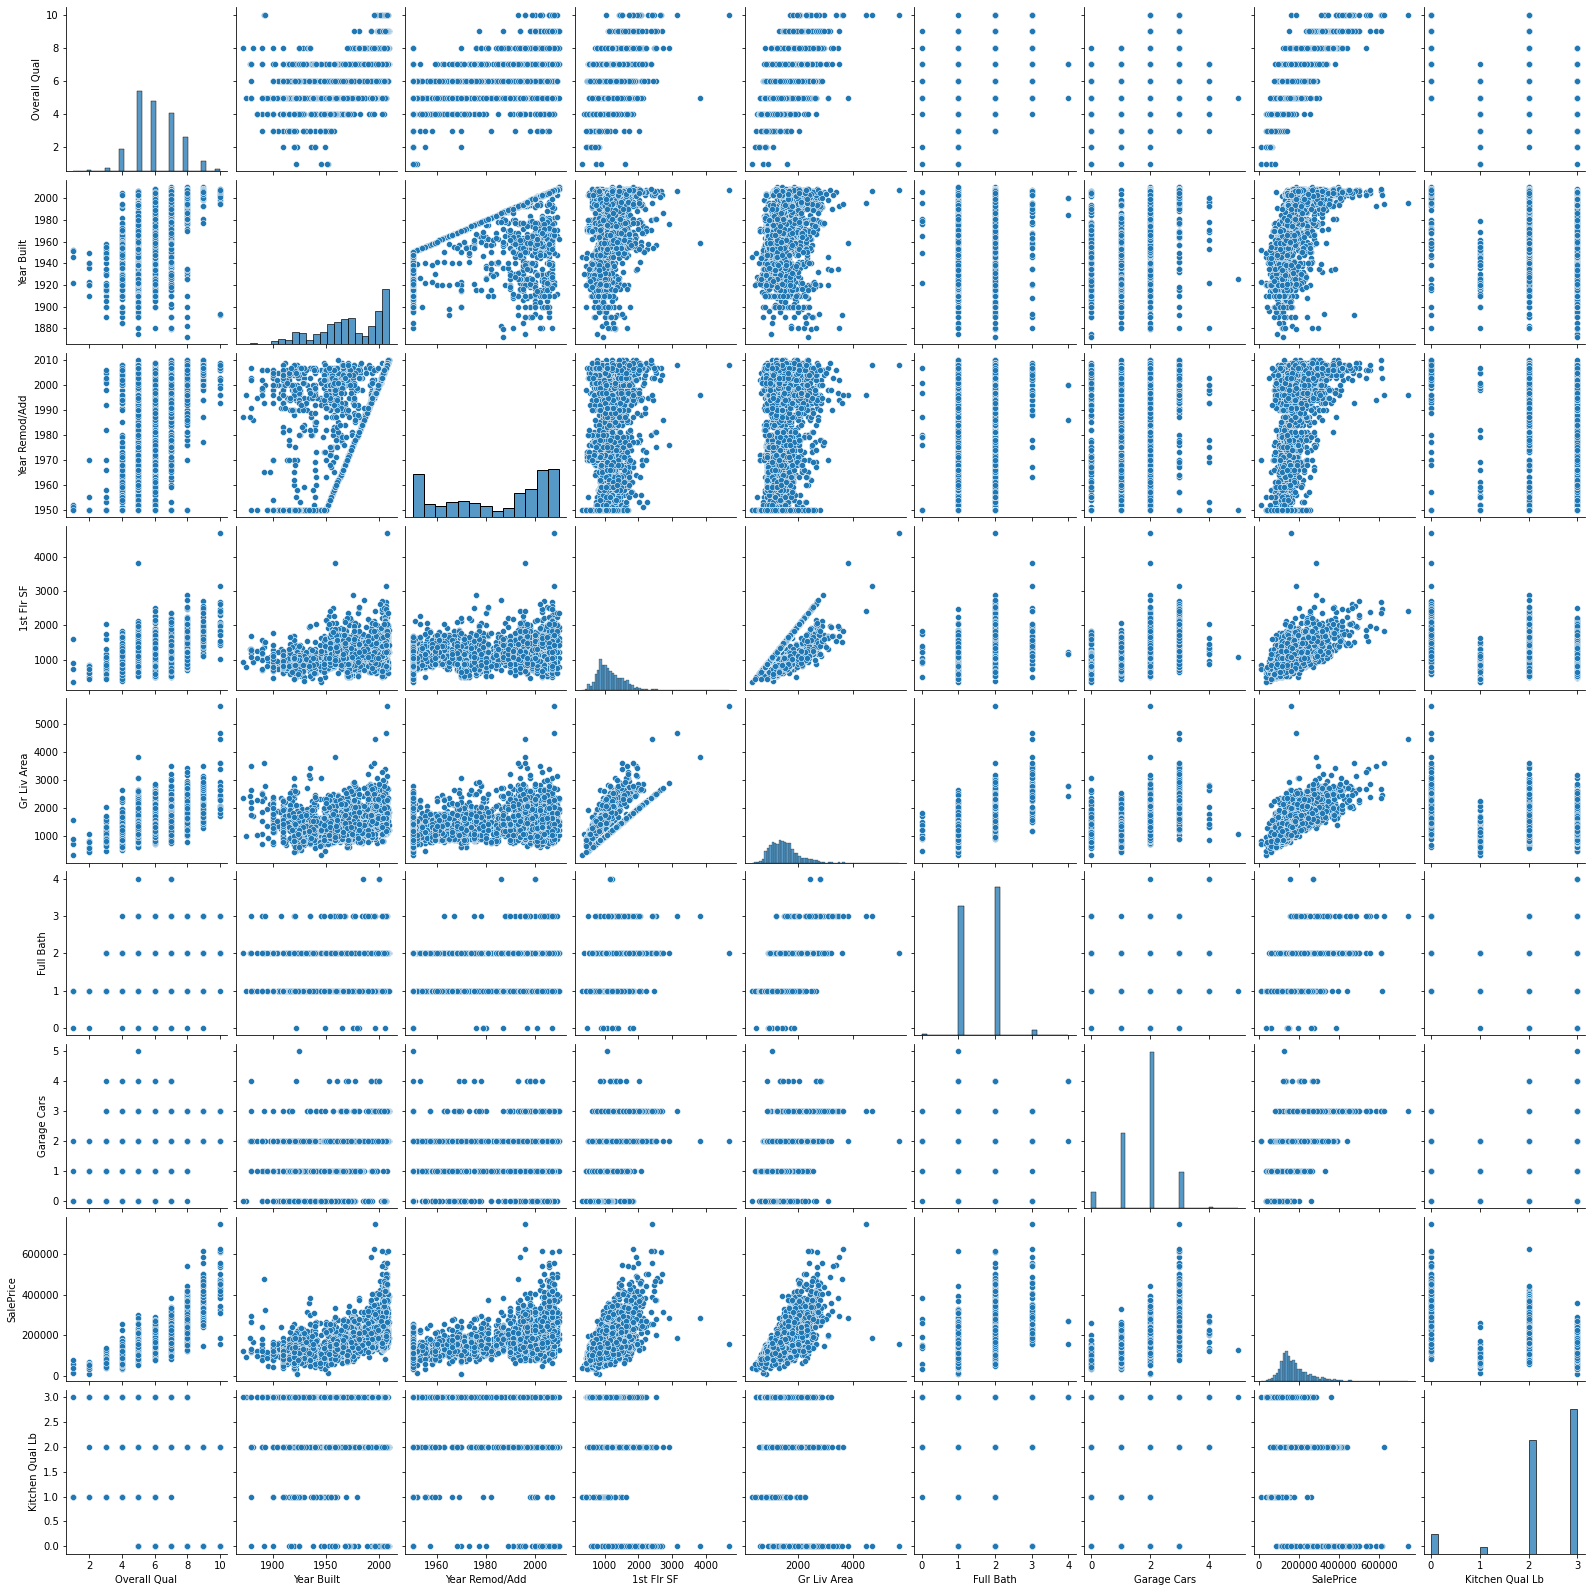

In [ ]:
# Showcase some columns with interesting observations
data_showcase = data_enc.copy()
data_showcase.drop(['Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF', 'TotRms AbvGrd',
                    'Fireplaces','Wood Deck SF', 'Open Porch SF', 'Lot Shape Lb', 'Foundation Lb',
                    'Bsmt Exposure Lb', 'Heating QC Lb', 'Garage Type Lb', 'Garage Finish Lb'], inplace=True, axis=1)
sns.pairplot(data_showcase)

### Observations

Sale Price shows the following relationships with predictors:

* Sale Price increases as Overall Quality increases.

* Sale Price rises at an increasing rate starting in the year 2000.

* Sale Price increases as square footage and living area increase. However there were some outliers where a low sale price was observed for a couple of houses that had very high square footage.

* Sale Price increases as the number of Full Baths and Garage Cars increase.

* Sale Price is positively affected by Excellent Kitchen Quality but lower levels of Kitchen Quality seem to have a nominal effect on Sale Price.

### Plots of Observations

Text(0.5, 1.0, 'Sale Price Increasing Rate')

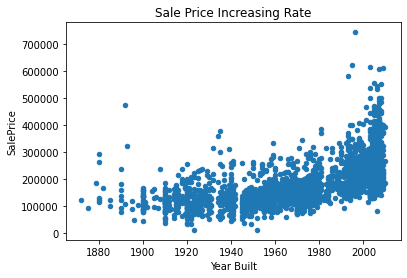

In [ ]:
# Price increases at increasing rate after 2000
data_enc.plot('Year Built', 'SalePrice', kind = 'scatter')
plt.title('Sale Price Increasing Rate')

Text(0.5, 1.0, 'When Year Built = Year Remodeled')

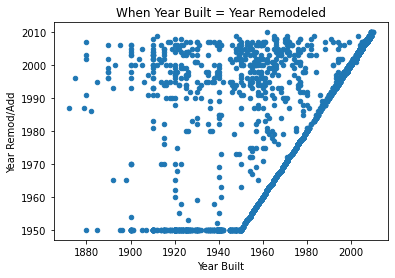

In [ ]:
# Year Built and Year Remodeled will be the same if the house was not remodeled
data_enc.plot('Year Built', 'Year Remod/Add', kind = 'scatter')
plt.title('When Year Built = Year Remodeled')

Text(0.5, 1.0, 'When Single Level Home')

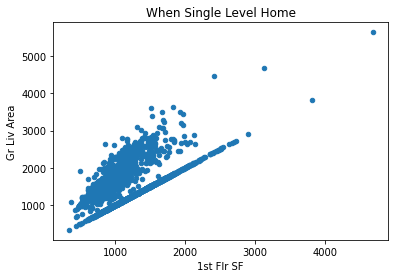

In [ ]:
# Gr Liv Area = 1st Flr SF in many cases. This indicates a single story house.
data_enc.plot('1st Flr SF', 'Gr Liv Area', kind = 'scatter')
plt.title('When Single Level Home')

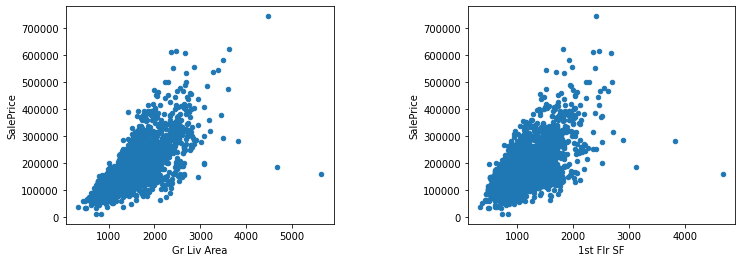

In [ ]:
# Sale Price trends up when square feet increases. 
# However there are some outliers with low price and large square feet.
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
plt.subplots_adjust(wspace=.5)

data_enc.plot('Gr Liv Area', 'SalePrice', kind = 'scatter', ax=ax1)
data_enc.plot('1st Flr SF', 'SalePrice', kind = 'scatter', ax=ax2)


## Distributions

**Steps:**

1. Look at distribution of SalePrice.
1. Identify average SalePrice by Discrete and Ordinal predictors to further confirm effect such predictors have on SalePrice.
1. Identify outliers to determine course of action.


Text(0.5, 1.0, 'Sale Price Distribution')

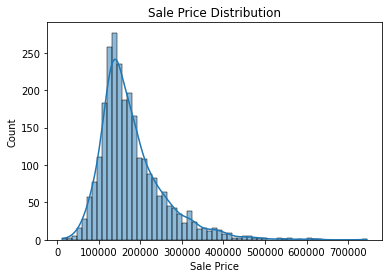

In [ ]:
# Look at distribution of SalePrice
# Result indicates data is right skewed with some outliers
sns.histplot(data_enc['SalePrice'], kde=True)
plt.xlabel('Sale Price')
plt.ylabel("Count")
plt.title('Sale Price Distribution')

Sale Price Statistics
count      2637.000000
mean     179986.230186
std       78309.251522
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213000.000000
max      745000.000000
Name: SalePrice, dtype: float64





Text(0.5, 1.0, 'Box Plot of Sale Price')

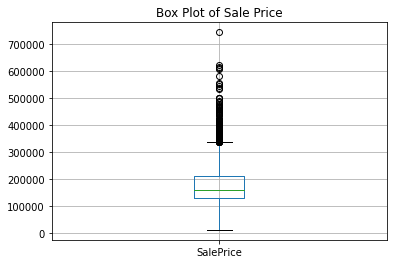

In [ ]:
# Prepare boxplot to visualize outliers and statistics for Sale Price
print('Sale Price Statistics')
print(data_enc['SalePrice'].describe())
print('\n'*2)
data_enc.boxplot(column='SalePrice')
plt.title('Box Plot of Sale Price')

Sale Price is positively skewed with most values falling between \$130,000 and \$213,000. The average sale price is around \$180,000 with outliers starting at around \$330,000.

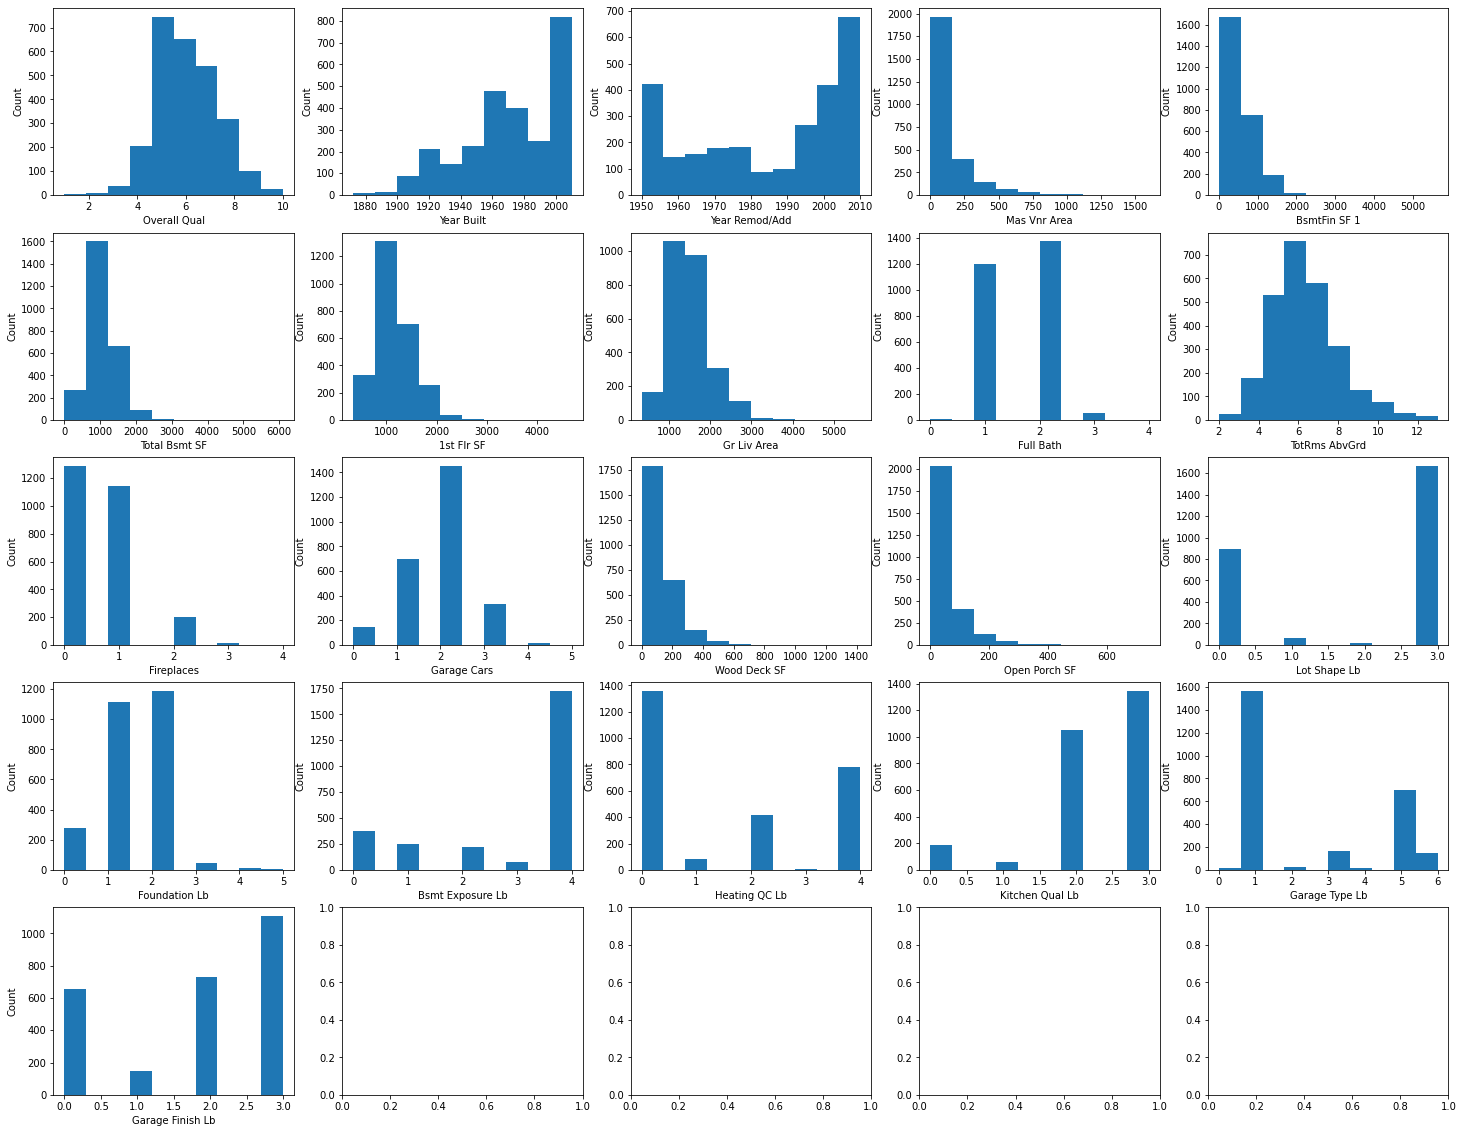

In [ ]:
# Look at distributions for remaining predictors
data_to_plot = data_enc.drop(['SalePrice'], axis = 1).copy()
fig, axs = plt.subplots(5,5, figsize = (25,20)) 
column_names = data_to_plot.columns
n = 0
for i in range(5): # Loop through rows 
  for j in range(5): # Loop through columns
    # To prevent index out of bounds error if necessary
    if not (i == 4 and j > 0):
      axs[i,j].hist(data_to_plot[column_names[n]])
      axs[i,j].set_xlabel(column_names[n])
      axs[i,j].set_ylabel('Count')
      n = n + 1

### Observations - Histograms

* Year built is highly skewed toward newer houses built after 2000 with a normal distribution of houses built between 1940 and 2000.

* Year Remod/Add is equal to the year built if the house was *not* remodeled. So this may indicate that **the year remodeled is not a useful predictor**.

* Total Bsmt SF, 1st Flr SF, Gr Liv Area, Mas Vnr Area, Wood Deck SF and Open Porch SF are skewed toward lower square footages. This indicates that the data **will require feature scaling** to achieve a more accurate prediction.

* Full Bath and Garage Cars are discrete.

* Overall Quality and Kitchen Quality are ordinal. However, 


In [ ]:
# List final predictor column names
column_names

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',
       'Wood Deck SF', 'Open Porch SF', 'Lot Shape Lb', 'Foundation Lb',
       'Bsmt Exposure Lb', 'Heating QC Lb', 'Kitchen Qual Lb',
       'Garage Type Lb', 'Garage Finish Lb'],
      dtype='object')

In [ ]:
# Identify average sale price by discrete and ordinal predictors
print(data_enc.groupby('Overall Qual')['SalePrice'].mean().round())
print(data_enc.groupby('Year Built')['SalePrice'].mean().round())
print(data_enc.groupby('Full Bath')['SalePrice'].mean().round())
print(data_enc.groupby('TotRms AbvGrd')['SalePrice'].mean().round())
print(data_enc.groupby('Fireplaces')['SalePrice'].mean().round())
print(data_enc.groupby('Garage Cars')['SalePrice'].mean().round())
print(data_enc.groupby('Lot Shape Lb')['SalePrice'].mean().round())
print(data_enc.groupby('Foundation Lb')['SalePrice'].mean().round())
print(data_enc.groupby('Bsmt Exposure Lb')['SalePrice'].mean().round())
print(data_enc.groupby('Heating QC Lb')['SalePrice'].mean().round())
print(data_enc.groupby('Kitchen Qual Lb')['SalePrice'].mean().round())
print(data_enc.groupby('Garage Type Lb')['SalePrice'].mean().round())
print(data_enc.groupby('Garage Finish Lb')['SalePrice'].mean().round())

Overall Qual
1      48725.0
2      48783.0
3      81768.0
4     105836.0
5     134980.0
6     161039.0
7     204109.0
8     269078.0
9     362322.0
10    444662.0
Name: SalePrice, dtype: float64
Year Built
1872    122000.0
1875     94000.0
1879    185000.0
1880    186696.0
1882    168000.0
          ...   
2006    258050.0
2007    266483.0
2008    304862.0
2009    279310.0
2010    283116.0
Name: SalePrice, Length: 118, dtype: float64
Full Bath
0    176834.0
1    134920.0
2    214099.0
3    312880.0
4    232667.0
Name: SalePrice, dtype: float64
TotRms AbvGrd
2      39300.0
3     106483.0
4     128140.0
5     143045.0
6     162689.0
7     198060.0
8     218515.0
9     251946.0
10    277498.0
11    315791.0
12    220484.0
13    205000.0
Name: SalePrice, dtype: float64
Fireplaces
0    141393.0
1    212586.0
2    236989.0
3    255821.0
4    260000.0
Name: SalePrice, dtype: float64
Garage Cars
0.0    104577.0
1.0    127732.0
2.0    183041.0
3.0    308671.0
4.0    209320.0
5.0    126500.0
Nam

### Observations - Sale Price Averages by Predictor

* Increased Overall Quality shows a steady increase in average Sale Price.

* Garage size up to 3 car garages shows an increase in average Sale Price. However any additional increase in garage size does not positively affect Sale Price.

* Excellent Kitchen quality correlates with a large average Sale Price. However any other Kitchen Quality does not correlate with a larger Sale Price. **Therefore, Kitchen Quality may not be considered further as a Sale Price predictor**.

 * _NOTE: re-ran regression models and discovered that Kitchen Quality **did** have a strong impact on Sale Price. So Kitchen quality was reinstated as a predictor._

* Houses built more recently result in a higher average Sale Price especially for those built after the year 2000.

* The number of full baths up to 3 results in a higher average Sale Price.

* Attached garages and finished garages result in a higher average Sale Price.

* Lot Shape does not seem to have much of an effect on Sale Price.



In [ ]:
# List final predictor column names
column_names

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',
       'Wood Deck SF', 'Open Porch SF', 'Lot Shape Lb', 'Foundation Lb',
       'Bsmt Exposure Lb', 'Heating QC Lb', 'Kitchen Qual Lb',
       'Garage Type Lb', 'Garage Finish Lb'],
      dtype='object')

## EDA Summary

After analyzing the data, looking at correlations between predictors and correlations with SalePrice, the following predictors were chosen to model against SalePrice:

* Overall Quality
* Year Built
* Year Remodeled
* Masonry Veneer Area --> brick, stone
* Basement Finished Square Footage
* Total Basement Square Footage
* 1st Floor Square Footage
* Above Ground Living Area
* Number of Full Baths
* Number of Rooms above ground
* Number of fire places
* Garage size, type, and finish
* Wood Deck size
* Open Porch size
* Lot Shape
* Foundation Type
* Heating Quality
* Kitchen Quality

#### Outliers

Sale Price has significant outliers (house prices exceeding \$330,000) that need to be addressed when fitting the regression model.

There were cases where a low sale price (under \$200,000) was observed with a very high living area (over 3,000 SF). These outliers should be addressed.

# Processing

The goal of this project is to predict house Sale Price using a number of predictors/features. A successful model will demonstrate a relatively low Root Mean Squared Error (RMSE) and low Root Mean Squared Percentage Error (RMSPE). RMSPE lower than 20% is considered successful.

 [Slides](https://docs.google.com/presentation/d/1uMKqprz6tjWaGdzyXc2KAc5rGqZYdXC_/edit#slide=id.gdabdebda8f_0_61)

 [Example](https://colab.research.google.com/drive/1T59pwLHro8Hoj6hhgnAz-i4ShH5wm-jh)
 



## Prepare Test Data

In [ ]:
# Experiment with dropping individual columns to see effect on result.
data_run = data_enc.copy()
# data_run.drop(['Lot Shape Lb'], inplace=True, axis=1)

In [ ]:
# Break up data into training and testing sets
X = data_run.drop(['SalePrice'], axis = 1).copy()
y = data_run['SalePrice']

# random_state=5 --> to make tests reproducible 
# test_size=0.2 --> 20% of data. Default for test_size and train_size is 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, train_size = 0.25, random_state=5)

## Linear Regression

### RMSPE for Linear Regression

In [ ]:
# Fit a linear model using Sklearn
my_fit_lr = LinearRegression(normalize = True)
my_fit_lr = my_fit_lr.fit(X_train, y_train)

label_lr = 'Linear'

y_pred_lr = my_fit_lr.predict(X_test)
print_model_results(y_test, y_pred_lr, label_lr)


Linear
RMSE: $27181.91
RMSPE: 17.29%


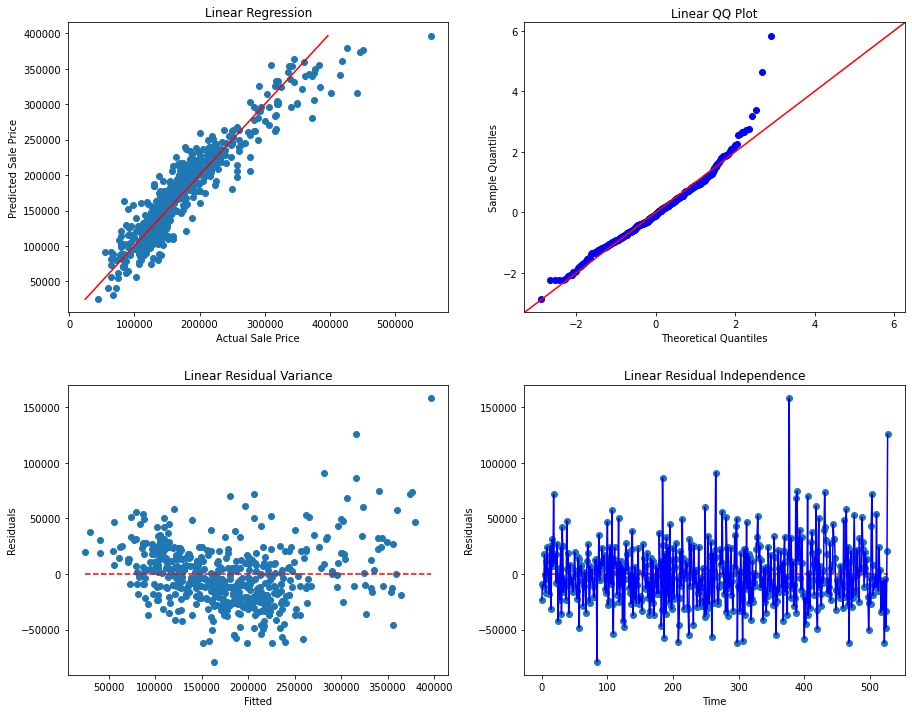

In [344]:
# Visualize results
# https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(2,2, figsize = (15,12))
plt.subplots_adjust(hspace=.25)

axs[0,0].plot([min(y_pred_lr), max(y_pred_lr)],[min(y_pred_lr), max(y_pred_lr)], c='red')
axs[0,0].scatter(y_test, y_pred_lr)
axs[0,0].set_xlabel('Actual Sale Price')
axs[0,0].set_ylabel('Predicted Sale Price')
axs[0,0].set_title(f'{label_lr} Regression')

res_lr = y_test - y_pred_lr
sm.qqplot(res_lr, fit=True, line="45", ax=axs[0,1])
axs[0,1].set_title(f'{label_lr} QQ Plot')

axs[1,0].scatter(y_pred_lr, res_lr)
axs[1,0].set_xlabel("Fitted")
axs[1,0].set_ylabel("Residuals")
axs[1,0].set_title(f'{label_lr} Residual Variance')
axs[1,0].hlines(0, min(y_pred_lr), max(y_pred_lr), colors = 'red', linestyles = 'dashed')

axs[1,1].scatter(range(len(res_lr)), res_lr)
axs[1,1].plot(range(len(res_lr)), res_lr, 'b')
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Residuals")
axs[1,1].set_title(f'{label_lr} Residual Independence')
axs[1,1].hlines(0, min(range(len(res_lr))), max(range(len(res_lr))), colors = 'red', linestyles = 'dashed')


In [ ]:
# Create a data frame with the results from the linear regression model
model_results = pd.DataFrame()
model_results['Predictor'] = X_train.columns
model_results[label_lr] = my_fit_lr.coef_

In [ ]:
# Calculate CV RMSE
cv_lr = cross_val_score(my_fit_lr, X, y, scoring='neg_mean_squared_error', cv = 10)
print_cv_results(cv_lr.mean(), label_lr)


Linear
CV RMSE: $31508.9
CV RMSPE: 17.72%


## Regularization

Helps with overfitting (high variance, low bias) with large datasets. Shrinks regression model coefficient estimates towards zero.

* Ridge Regression
* Lasso Regression

[Slides](https://docs.google.com/presentation/d/1m2vJB58QWDLDtW-A244J4y8TcNH867j3G_UyeULUe9w/edit#slide=id.gdd52504e00_0_0)

[Examples](https://colab.research.google.com/drive/1rHyd135SB8Xk_xyALCNRsjzhavMghL5q)

### Ridge Regression

In [ ]:
# Train the model
# Note: normalize=True is doing feature scaling.
my_fit_rr = Ridge(alpha = 1, normalize = True) # Arbitrarily choosing alpha = 1
my_fit_rr = my_fit_rr.fit(X_train, y_train)

label_rr = 'Ridge'

#### RMSPE for Ridge Regression

In [ ]:
# Calculate RMSE for prediction based on actual values using model with alpha score 1
y_pred_rr_b = my_fit_rr.predict(X_test)
print_model_results(y_test, y_pred_rr_b, label_rr)


Ridge Before Alpha
RMSE: $29709.56
RMSPE: 17.34%


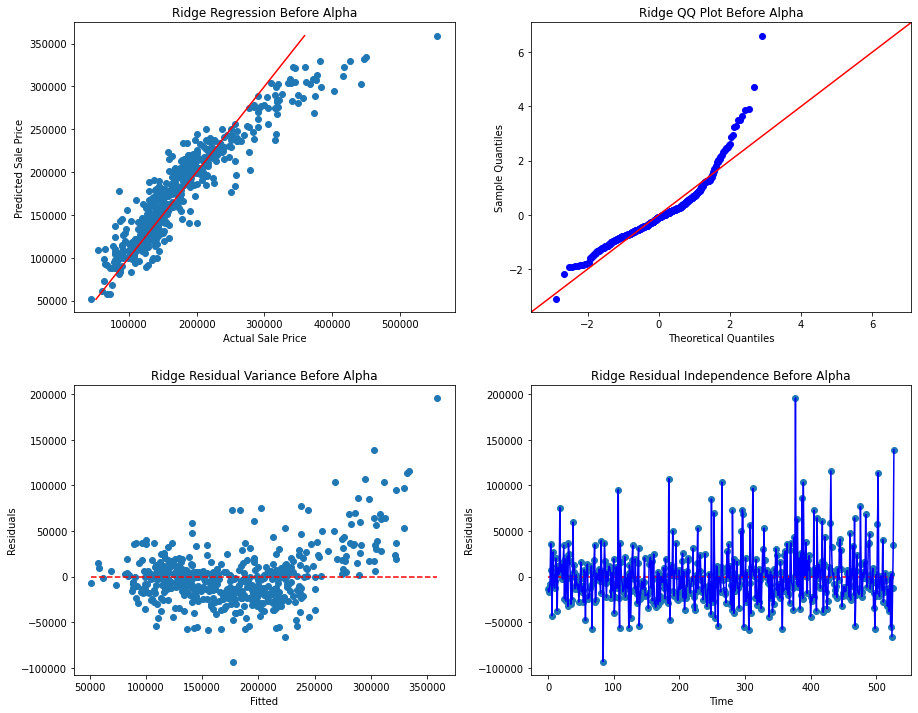

In [347]:
# Visualize results
fig, axs = plt.subplots(2,2, figsize = (15,12))
plt.subplots_adjust(hspace=.25)

axs[0,0].plot([min(y_pred_rr_b), max(y_pred_rr_b)],[min(y_pred_rr_b), max(y_pred_rr_b)], c='red')
axs[0,0].scatter(y_test, y_pred_rr_b)
axs[0,0].set_xlabel('Actual Sale Price')
axs[0,0].set_ylabel('Predicted Sale Price')
axs[0,0].set_title(f'{label_rr} Regression Before Alpha')

res_rr = y_test - y_pred_rr_b
sm.qqplot(res_rr, fit=True, line="45", ax=axs[0,1])
axs[0,1].set_title(f'{label_rr} QQ Plot Before Alpha')

axs[1,0].scatter(y_pred_rr_b, res_rr)
axs[1,0].set_xlabel("Fitted")
axs[1,0].set_ylabel("Residuals")
axs[1,0].set_title(f'{label_rr} Residual Variance Before Alpha')
axs[1,0].hlines(0, min(y_pred_rr_b), max(y_pred_rr_b), colors = 'red', linestyles = 'dashed')

axs[1,1].scatter(range(len(res_rr)), res_rr)
axs[1,1].plot(range(len(res_rr)), res_rr, 'b')
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Residuals")
axs[1,1].set_title(f'{label_rr} Residual Independence Before Alpha')
axs[1,1].hlines(0, min(range(len(res_rr))), max(range(len(res_rr))), colors = 'red', linestyles = 'dashed')

In [ ]:
# Specify values of alpha we want to try 
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph: 
  # Train the model
  my_fit_rr = Ridge(alpha = i, normalize = True) # Looping through alpha
  my_fit_rr = my_fit_rr.fit(X_train, y_train)

  # Calculate CV RMSE
  cv_rr = cross_val_score(my_fit_rr, X, y, scoring='neg_mean_squared_error', cv = 10)
  rmse = np.sqrt(abs(cv_rr.mean()))
  results_alpha.append(rmse)

results_df_rr = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
a_val_rr = results_df_rr[results_df_rr['RMSE'] == results_df_rr['RMSE'].min()]['Alpha'].values[0]

In [ ]:
# Retrain the model w/ new alpha score
# a_val = 1
my_fit_rr = Ridge(alpha = a_val_rr, normalize = True) 
my_fit_rr.fit(X_train, y_train)

# Calculate CV RMSE
cv_rr = cross_val_score(my_fit_rr, X, y, scoring='neg_mean_squared_error', cv = 10)
print_cv_results(cv_rr.mean(), label_rr)


Ridge
CV RMSE: $31481.98
CV RMSPE: 17.71%


In [ ]:
# Calculate RMSE for prediction based on actual values using new alpha
y_pred_rr_a = my_fit_rr.predict(X_test)
print_model_results(y_test, y_pred_rr_a, label_rr, False)


Ridge After Alpha
RMSE: $27125.75
RMSPE: 17.22%


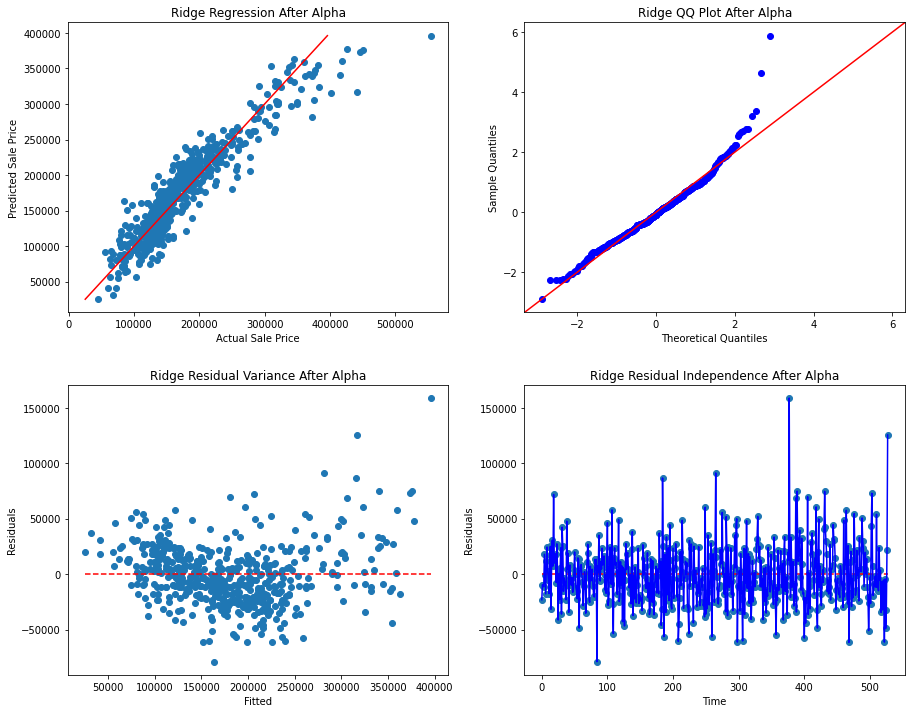

In [346]:
# Visualize results using final model
fig, axs = plt.subplots(2,2, figsize = (15,12))
plt.subplots_adjust(hspace=.25)

axs[0,0].plot([min(y_pred_rr_a), max(y_pred_rr_a)],[min(y_pred_rr_a), max(y_pred_rr_a)], c='red')
axs[0,0].scatter(y_test, y_pred_rr_a)
axs[0,0].set_xlabel('Actual Sale Price')
axs[0,0].set_ylabel('Predicted Sale Price')
axs[0,0].set_title(f'{label_rr} Regression After Alpha')

res_rr = y_test - y_pred_rr_a
sm.qqplot(res_rr, fit=True, line="45", ax=axs[0,1])
axs[0,1].set_title(f'{label_rr} QQ Plot After Alpha')

axs[1,0].scatter(y_pred_rr_a, res_rr)
axs[1,0].set_xlabel("Fitted")
axs[1,0].set_ylabel("Residuals")
axs[1,0].set_title(f'{label_rr} Residual Variance After Alpha')
axs[1,0].hlines(0, min(y_pred_rr_a), max(y_pred_rr_a), colors = 'red', linestyles = 'dashed')

axs[1,1].scatter(range(len(res_rr)), res_rr)
axs[1,1].plot(range(len(res_rr)), res_rr, 'b')
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Residuals")
axs[1,1].set_title(f'{label_rr} Residual Independence After Alpha')
axs[1,1].hlines(0, min(range(len(res_rr))), max(range(len(res_rr))), colors = 'red', linestyles = 'dashed')

In [ ]:
# Add ridge regression results to data frame we created earlier
model_results[label_rr] = my_fit_rr.coef_

### Lasso Regression

In [ ]:
my_fit_lasso = Lasso(alpha = 1, normalize = True, tol = .1, max_iter=1000000)
my_fit_lasso.fit(X_train, y_train)

label_lasso = 'Lasso'

#### RMSPE for Lasso Regression

In [ ]:
# Calculate RMSE for prediction based on actual values using model with alpha score 1
y_pred_lasso_b = my_fit_lasso.predict(X_test)
print_model_results(y_test, y_pred_lasso_b, label_lasso)


Lasso Before Alpha
RMSE: $27201.83
RMSPE: 17.22%


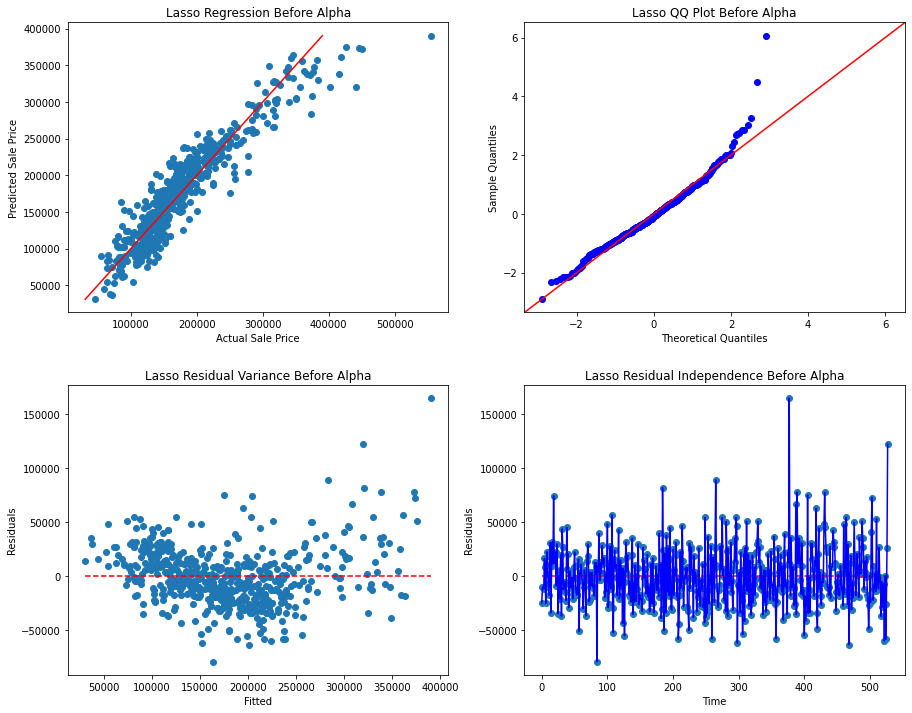

In [348]:
# Visualize results
fig, axs = plt.subplots(2,2, figsize = (15,12))
plt.subplots_adjust(hspace=.25)

axs[0,0].plot([min(y_pred_lasso_b), max(y_pred_lasso_b)],[min(y_pred_lasso_b), max(y_pred_lasso_b)], c='red')
axs[0,0].scatter(y_test, y_pred_lasso_b)
axs[0,0].set_xlabel('Actual Sale Price')
axs[0,0].set_ylabel('Predicted Sale Price')
axs[0,0].set_title(f'{label_lasso} Regression Before Alpha')

res_lasso = y_test - y_pred_lasso_b
sm.qqplot(res_lasso, fit=True, line="45", ax=axs[0,1])
axs[0,1].set_title(f'{label_lasso} QQ Plot Before Alpha')

axs[1,0].scatter(y_pred_lasso_b, res_lasso)
axs[1,0].set_xlabel("Fitted")
axs[1,0].set_ylabel("Residuals")
axs[1,0].set_title(f'{label_lasso} Residual Variance Before Alpha')
axs[1,0].hlines(0, min(y_pred_lasso_b), max(y_pred_lasso_b), colors = 'red', linestyles = 'dashed')

axs[1,1].scatter(range(len(res_lasso)), res_lasso)
axs[1,1].plot(range(len(res_lasso)), res_lasso, 'b')
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Residuals")
axs[1,1].set_title(f'{label_lasso} Residual Independence Before Alpha')
axs[1,1].hlines(0, min(range(len(res_lasso))), max(range(len(res_lasso))), colors = 'red', linestyles = 'dashed')

In [ ]:
# Specify values of alpha we want to try 
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph: 
  # Train the model
  # Note had to increase tolerance from .01 to .1 to avoid ConvergenceWarning.
  my_fit_lasso = Lasso(alpha = i, normalize = True, tol = .1, max_iter=1000000) # Looping through alpha
  my_fit_lasso.fit(X_train, y_train)
  
  # Calculate CV RMSE
  cv_lasso = cross_val_score(my_fit_lasso, X, y, scoring='neg_mean_squared_error', cv = 10)
  rmse = np.sqrt(abs(cv_lasso.mean()))
  results_alpha.append(rmse)

results_df_lasso = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
a_val_lasso = results_df_lasso[results_df_lasso['RMSE'] == results_df_lasso['RMSE'].min()]['Alpha'].values[0]

In [ ]:
# re-train the model with best alpha
my_fit_lasso = Lasso(alpha = a_val_lasso, normalize = True, tol = .1, max_iter=1000000) 
my_fit_lasso.fit(X_train, y_train)

# Calculate CV RMSE
cv_lasso = cross_val_score(my_fit_lasso, X, y, scoring='neg_mean_squared_error', cv = 10)
print_cv_results(cv_lasso.mean(), label_lasso)


Lasso
CV RMSE: $31618.33
CV RMSPE: 17.78%


In [ ]:
y_pred_lasso_a = my_fit_lasso.predict(X_test)
print_model_results(y_test, y_pred_lasso_a, label_lasso, False)


Lasso After Alpha
RMSE: $27172.06
RMSPE: 17.17%


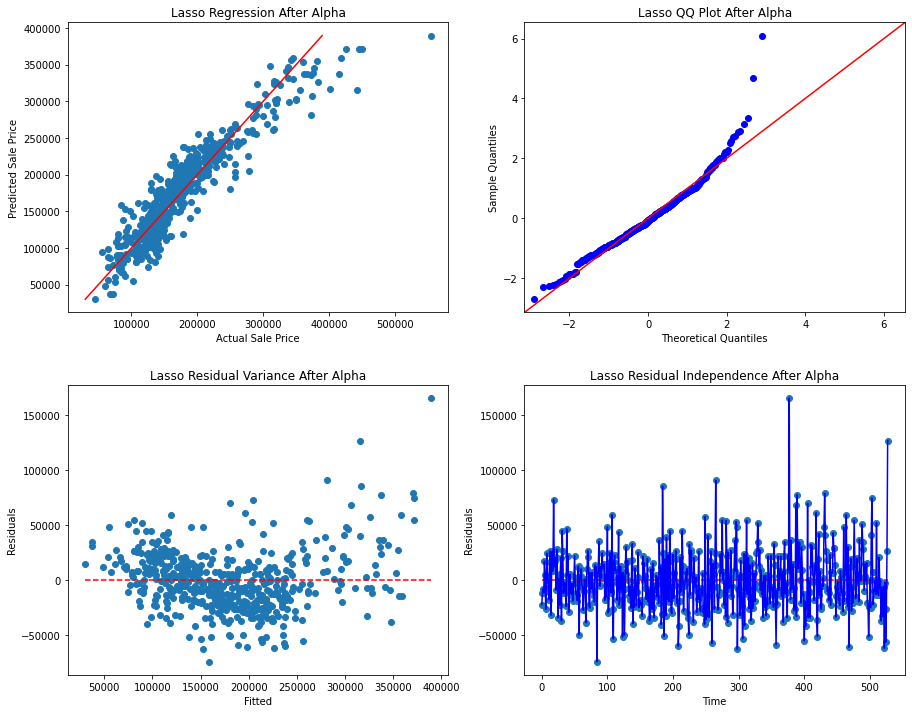

In [349]:
# Visualize results after minimal alpha applied.
fig, axs = plt.subplots(2,2, figsize = (15,12))
plt.subplots_adjust(hspace=.25)

axs[0,0].plot([min(y_pred_lasso_a), max(y_pred_lasso_a)],[min(y_pred_lasso_a), max(y_pred_lasso_a)], c='red')
axs[0,0].scatter(y_test, y_pred_lasso_a)
axs[0,0].set_xlabel('Actual Sale Price')
axs[0,0].set_ylabel('Predicted Sale Price')
axs[0,0].set_title(f'{label_lasso} Regression After Alpha')

res_lasso = y_test - y_pred_lasso_a
sm.qqplot(res_lasso, fit=True, line="45", ax=axs[0,1])
axs[0,1].set_title(f'{label_lasso} QQ Plot After Alpha')

axs[1,0].scatter(y_pred_lasso_a, res_lasso)
axs[1,0].set_xlabel("Fitted")
axs[1,0].set_ylabel("Residuals")
axs[1,0].set_title(f'{label_lasso} Residual Variance After Alpha')
axs[1,0].hlines(0, min(y_pred_lasso_a), max(y_pred_lasso_a), colors = 'red', linestyles = 'dashed')

axs[1,1].scatter(range(len(res_lasso)), res_lasso)
axs[1,1].plot(range(len(res_lasso)), res_lasso, 'b')
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Residuals")
axs[1,1].set_title(f'{label_lasso} Residual Independence After Alpha')
axs[1,1].hlines(0, min(range(len(res_lasso))), max(range(len(res_lasso))), colors = 'red', linestyles = 'dashed')

## Coefficients

In [ ]:
# Add Lasso results to the data frame we created before
model_results[label_lasso] = my_fit_lasso.coef_
model_results

,Predictor,Linear,Ridge,Lasso
0,Overall Qual,16795.999957,16424.964429,13923.332170
1,Year Built,152.446753,149.645944,115.807128
2,Year Remod/Add,171.954798,177.839380,229.368487
3,Mas Vnr Area,29.776550,30.135184,31.195798
4,BsmtFin SF 1,11.250924,11.068787,10.876793
5,Total Bsmt SF,2.255262,2.961541,2.233356
6,1st Flr SF,14.746288,14.263902,13.597242
7,Gr Liv Area,11.609399,12.008174,16.695986
8,Full Bath,2031.576635,2288.504141,3605.172660
9,TotRms AbvGrd,5392.635454,5287.176422,4376.206290


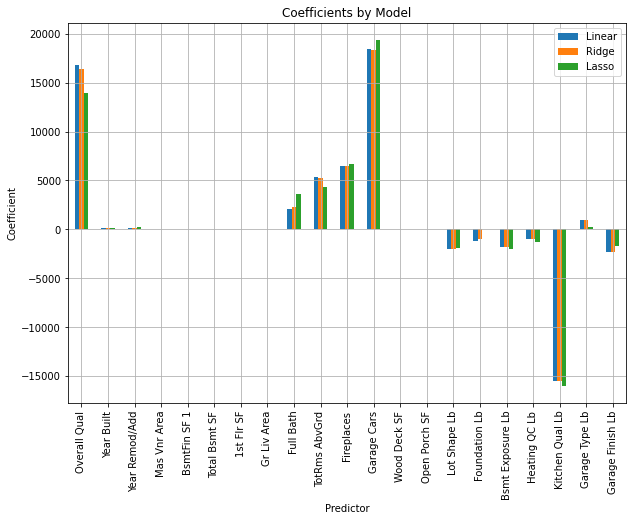

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1, figsize = (10,7))
model_results.plot(x = 'Predictor', kind = 'bar', ax = ax)
ax.set_ylabel('Coefficient')
plt.title('Coefficients by Model')
plt.grid()

# Summary Statistics

In [ ]:
# Final results are in purple. Initial results are in blue.
print_model_results(y_test, y_pred_lr, label_lr, False)
print('-'* 20)

print_model_results(y_test, y_pred_rr_b, label_rr)
print_model_results(y_test, y_pred_rr_a, label_rr, False)
print('-'* 20)

print_model_results(y_test, y_pred_lasso_b, label_lasso)
print_model_results(y_test, y_pred_lasso_a, label_lasso, False)
print('-'* 20)

BOLD = '\033[1m'
GREEN = '\033[32m'
print(BOLD + GREEN + '\n\nSale Price Statistics')
print(data_enc['SalePrice'].describe())


Linear
RMSE: $27181.91
RMSPE: 17.29%
--------------------

Ridge Before Alpha
RMSE: $29709.56
RMSPE: 17.34%

Ridge After Alpha
RMSE: $27125.75
RMSPE: 17.22%
--------------------

Lasso Before Alpha
RMSE: $27201.83
RMSPE: 17.22%

Lasso After Alpha
RMSE: $27172.06
RMSPE: 17.17%
--------------------


Sale Price Statistics
count      2637.000000
mean     179986.230186
std       78309.251522
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213000.000000
max      745000.000000
Name: SalePrice, dtype: float64


# Conclusions

The best result was achieved with Lasso Regularization reducing the RMSPE from 17.29% error to 17.17% error and resulting in an RMSE error of $\pm$ \$ 27,172.

This RMSE seems high given median house prices at \$160,000. To further reduce the RMSE, I would recommend multiple pricing models for houses in different price ranges to allow us to more accurately predict average priced houses separately from expensive houses. Further analysis would be required to determine the price ranges for each data set. Additionally, more data would be needed for predicting higher priced housing since the data set used for this analyis contained insufficient data for predicting high house prices. 


